In [1]:
import numpy as np
import pandas as pd
import glob
import emcee
import corner

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from fit_just_early_lc import prep_light_curve

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path = "../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype_pec.csv")

##  Make final PDF plots

In [4]:
sn = 'ZTF18abclfee' #'ZTF18abgmcmv' #'ZTF18abukmty'  # 'ZTF18aazabmh' #'ZTF18aaqffyp' #'ZTF18abclfee'  
thin_by = 100
rel_flux_cutoff = 0.4

<IPython.core.display.Javascript object>


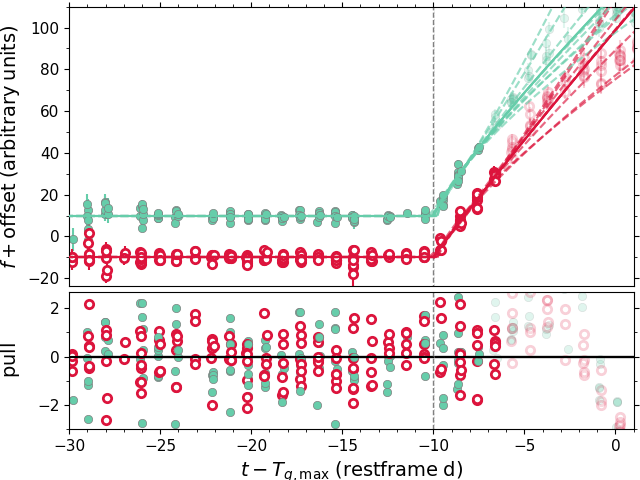

In [5]:
paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", r'$\alpha_{g}$',
             r"$A'_r$", r'$\alpha_{r}$']
thin_by = 100
rel_flux_cutoff = 0.4

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)

t_B_max = salt_df.t0_B_salt2.iloc[np.where(salt_df.name == sn)].values[0]
t_g_max = salt_df.t0_g_adopted.iloc[np.where(salt_df.name == sn)].values[0]

burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

#  correct B vs g offset
if salt_df.t0_salt2_unc.iloc[np.where(salt_df.name == sn)].values[0] == salt_df.t0_g_adopted_unc.iloc[np.where(salt_df.name == sn)].values[0]:
    t_offset = (t_g_max - t_B_max)/(1 + z)
    samples[:,0] += t_offset
    t_max = t_B_max

t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff, 
                                                                     return_masked=True)

max_posterior = samples[np.argmax(lnpost)]
haha = plot_both_filt(max_posterior, t_data, f_data, f_unc_data, fcqfid_data, plot_obs,
                      samples, np.random.choice(range(len(samples)), 8, replace=False),
                      landscape=False,
                      poster=False,
                      gmax=True)

# haha.savefig(info_path + 'big_unc/{}_model_lc.pdf'.format(sn))

In [6]:
haha.savefig(info_path + 'big_unc/{}_model_lc.pdf'.format(sn))

<IPython.core.display.Javascript object>


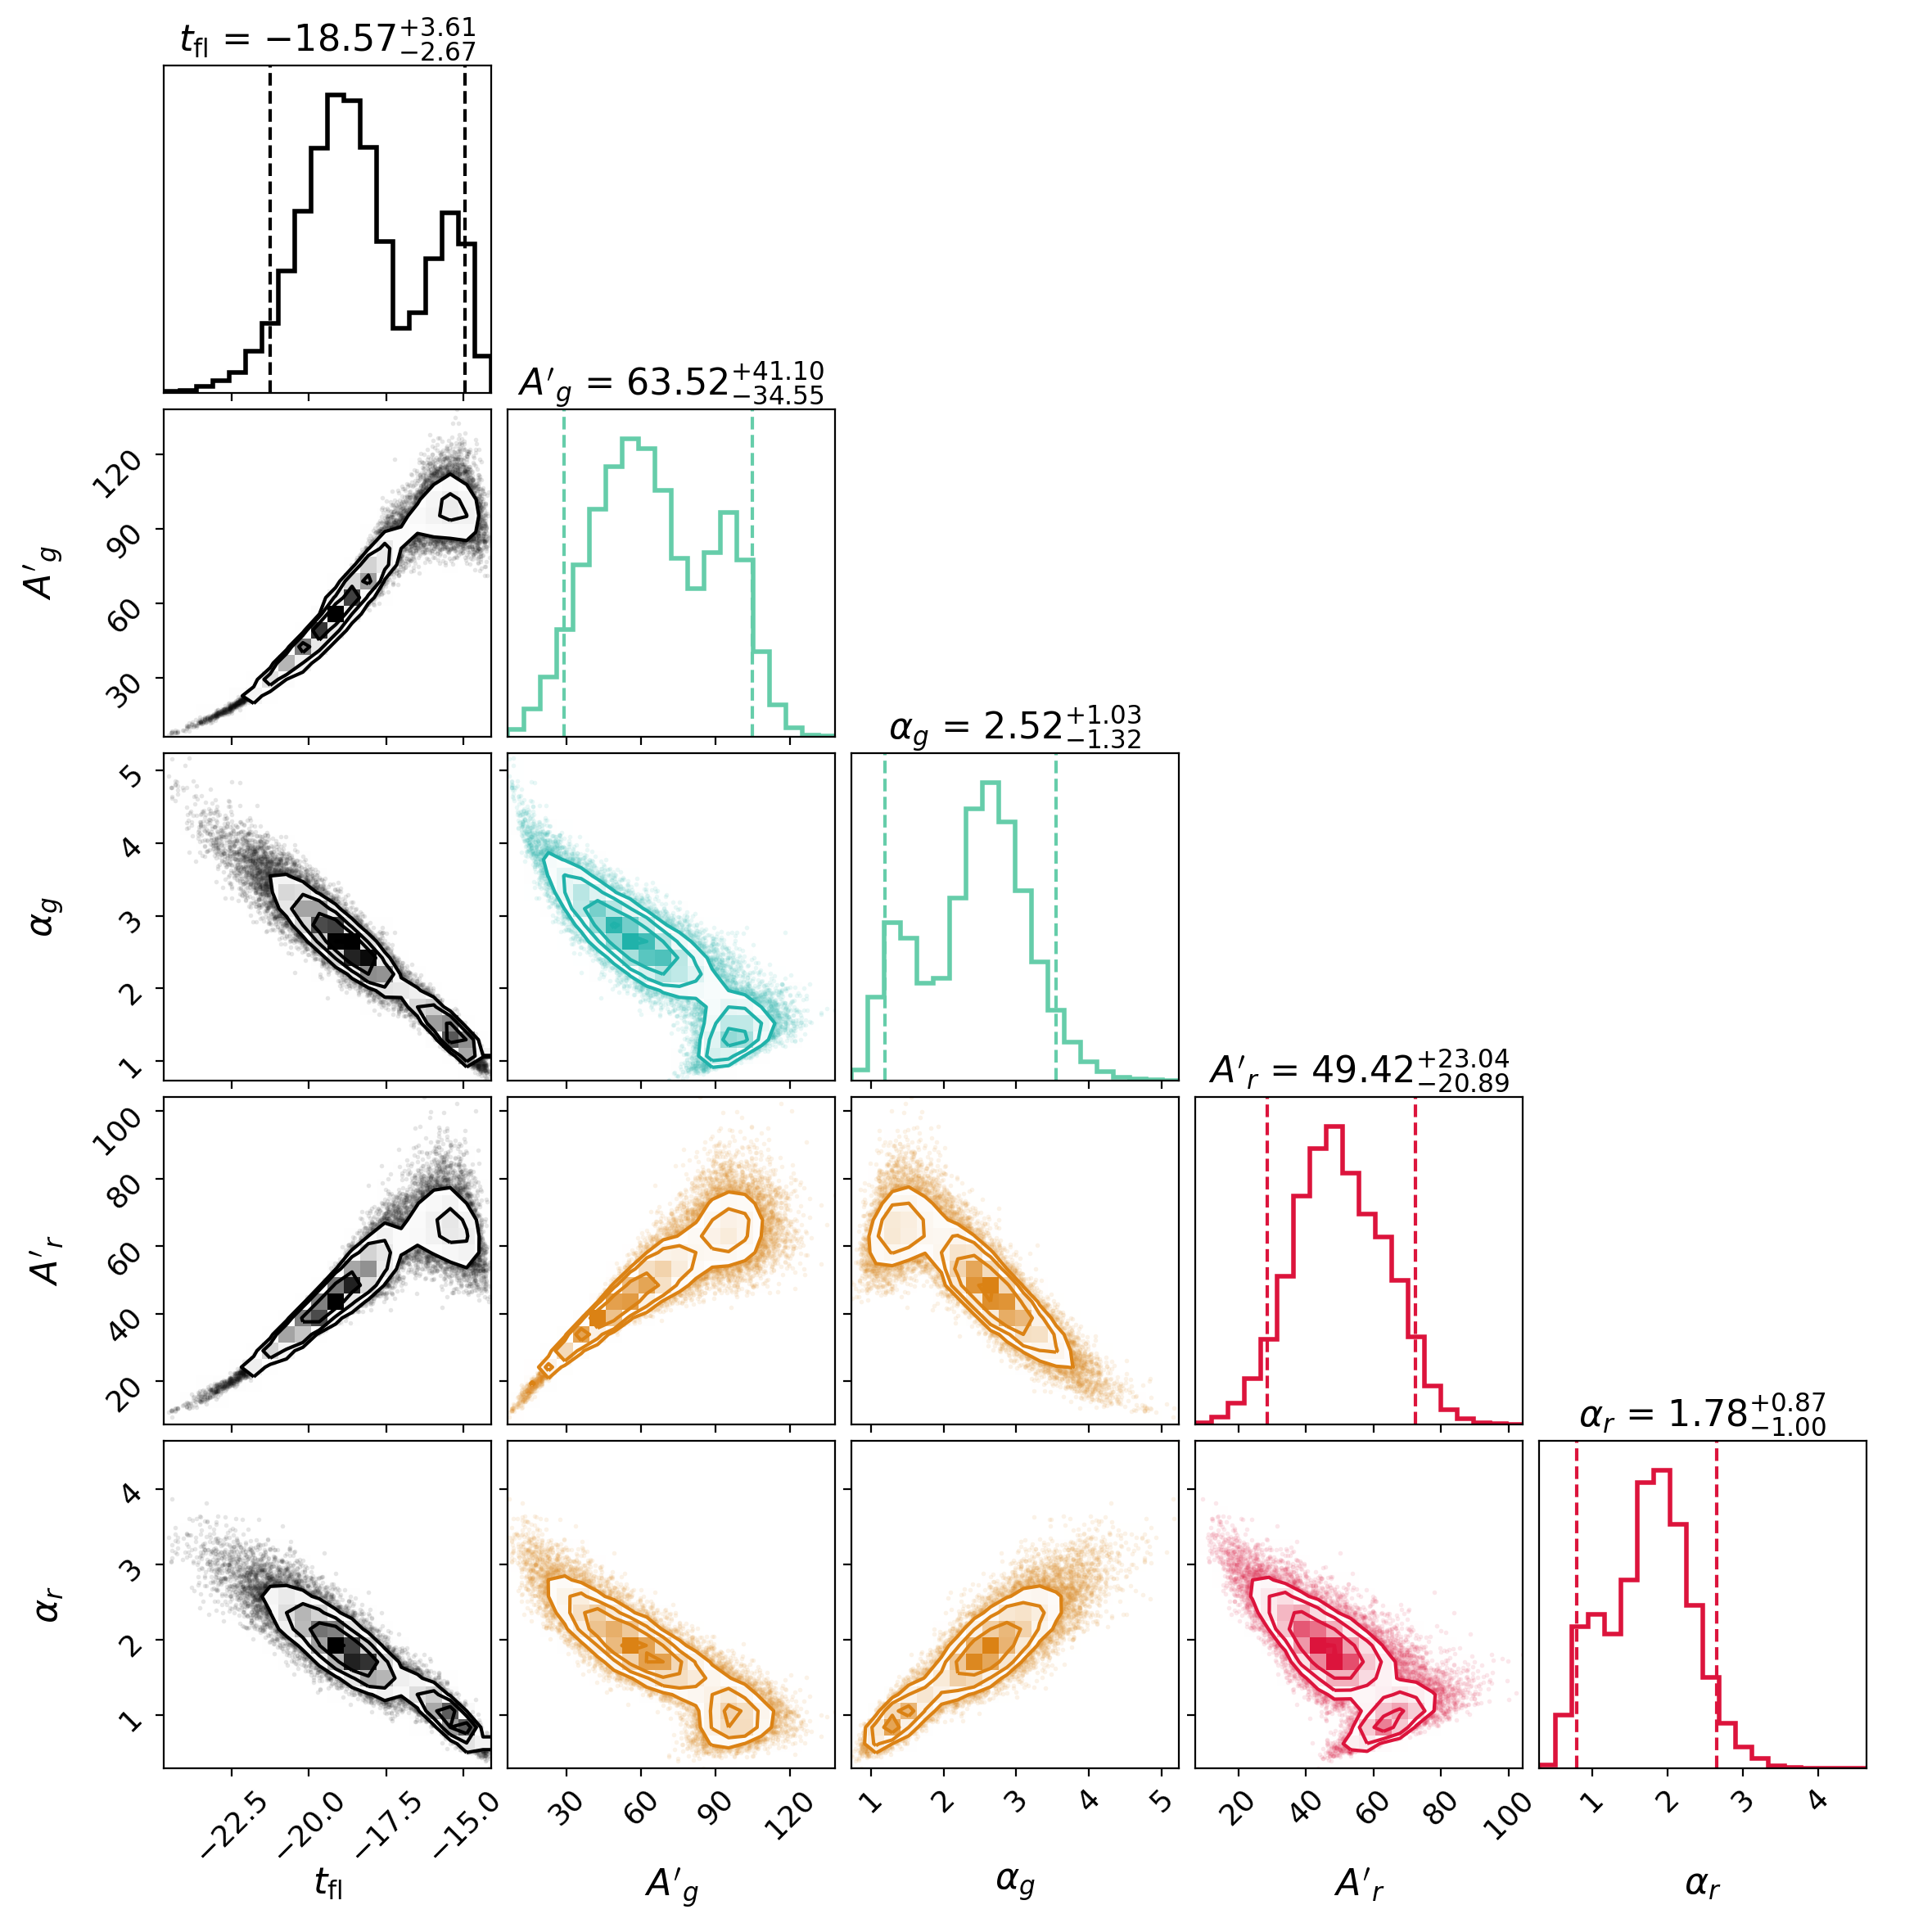

In [26]:
cfig = corner_hack(samples[:,0:5], labels=paramsNames, label_kwargs={'fontsize':16}, ticklabelsize=13,
                   show_titles=True, quantiles=[.05,.95], title_fmt=".2f", title_kwargs={'fontsize':16},
                   plot_datapoints=True, plot_contours=True)
cfig.savefig(info_path + 'big_unc/{}_corner.pdf'.format(h5_file.split('/')[-1].split('_')[0]))